# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.8 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-g8zp1hyg
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-g8zp1hyg
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 17.88 MiB/s, done.
Resolving deltas: 100% (3/3), done.


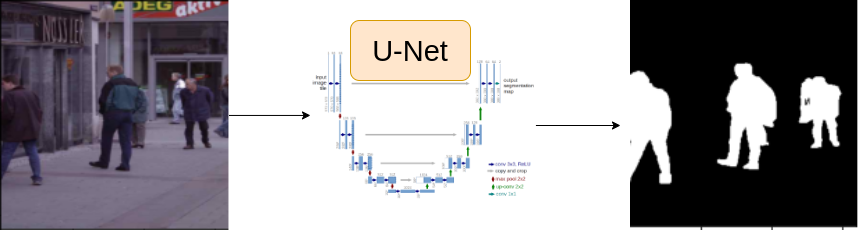

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DARA_DIR = '/content/'
DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[3]
Image_path = row.images
Mask_path = row.masks

image =cv2.imread(Image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(Mask_path, cv2.IMREAD_GRAYSCALE)/ 255.0

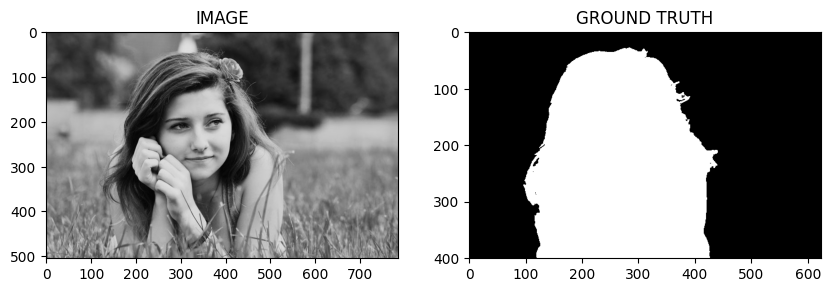

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df , valid_df = train_test_split(df, test_size = 0.2, random_state = 42)
#

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentaitionDataset(Dataset):
  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)
    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [14]:
trainset = SegmentaitionDataset(train_df, get_train_augs())
validset = SegmentaitionDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


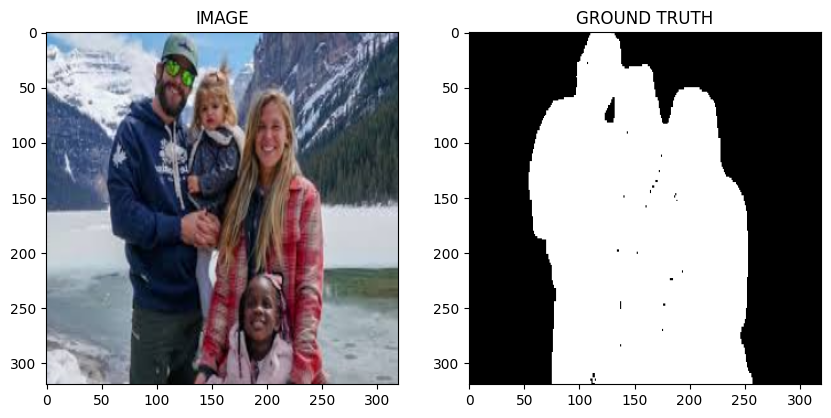

In [16]:
idx = 2
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [19]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [20]:
for image, mask in trainloader:
  break
print(f"Image batch shape : {image.shape}")
print(f"Mask mask shape : {mask.shape}")

Image batch shape : torch.Size([16, 3, 320, 320])
Mask mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [23]:
model = SegmentationModel().to(DEVICE)
model.to(DEVICE);

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Task 7 : Create Train and Validation Function

In [24]:
model.train()
total_loss = 0.0

# Assuming 'dataloader' and 'optimizer' are defined elsewhere or passed as arguments
# This code snippet appears to be part of a larger training loop function
# For this fix, I'm just correcting the syntax of the variable assignment.
# If this is intended to be a standalone train function, it needs proper function definition and arguments.

# Placeholder for a conceptual loop and optimizer usage, as the original code was incomplete as a function
# for images, masks in tqdm(dataloader):

#   images = images.to(DEVICE)
#   masks = masks.to(DEVICE)

#   optimizer.zero_grad()
#   logits, loss = model(images, masks)
#   loss.backward()
#   optimiser.step()

#   total_loss += loss.item()

# return total_loss / len(dataloader)

In [25]:
def valid_fn(model, dataloader):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(dataloader)

# Task 8 : Train Model

In [26]:
def train_fn(model, dataloader, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

best_valid_loss = np.inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = valid_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED BEST MODEL")

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


SAVED BEST MODEL
Epoch : 1 Train Loss : 0.6872558852036794 Valid Loss : 0.5806946605443954


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


SAVED BEST MODEL
Epoch : 2 Train Loss : 0.35086464285850527 Valid Loss : 0.5488862693309784


100%|██████████| 4/4 [00:00<00:00,  6.46it/s]


SAVED BEST MODEL
Epoch : 3 Train Loss : 0.2700558970371882 Valid Loss : 0.26130248978734016


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Epoch : 4 Train Loss : 0.23216376304626465 Valid Loss : 0.2966512702405453


100%|██████████| 4/4 [00:00<00:00,  6.46it/s]


Epoch : 5 Train Loss : 0.21284819940725963 Valid Loss : 0.2838791646063328


100%|██████████| 4/4 [00:00<00:00,  6.36it/s]


SAVED BEST MODEL
Epoch : 6 Train Loss : 0.2318565785884857 Valid Loss : 0.21834230050444603


100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


SAVED BEST MODEL
Epoch : 7 Train Loss : 0.2073335165778796 Valid Loss : 0.20450083166360855


100%|██████████| 4/4 [00:00<00:00,  6.22it/s]


Epoch : 8 Train Loss : 0.20126240253448485 Valid Loss : 0.20493654906749725


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch : 9 Train Loss : 0.17494436502456664 Valid Loss : 0.23066679760813713


100%|██████████| 4/4 [00:00<00:00,  6.41it/s]


Epoch : 10 Train Loss : 0.15824135541915893 Valid Loss : 0.26910458877682686


100%|██████████| 4/4 [00:00<00:00,  6.33it/s]


Epoch : 11 Train Loss : 0.17188146362702053 Valid Loss : 0.2558809667825699


100%|██████████| 4/4 [00:00<00:00,  6.21it/s]


Epoch : 12 Train Loss : 0.1537198712428411 Valid Loss : 0.24210230633616447


100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


Epoch : 13 Train Loss : 0.15056195110082626 Valid Loss : 0.20978258550167084


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Epoch : 14 Train Loss : 0.16228369275728863 Valid Loss : 0.28354036435484886


100%|██████████| 4/4 [00:00<00:00,  6.24it/s]


Epoch : 15 Train Loss : 0.15538042883078257 Valid Loss : 0.270610261708498


100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


Epoch : 16 Train Loss : 0.15846516837676367 Valid Loss : 0.20941497012972832


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Epoch : 17 Train Loss : 0.1415248066186905 Valid Loss : 0.21598763391375542


100%|██████████| 4/4 [00:00<00:00,  6.44it/s]


SAVED BEST MODEL
Epoch : 18 Train Loss : 0.11935298442840576 Valid Loss : 0.19562117755413055


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


SAVED BEST MODEL
Epoch : 19 Train Loss : 0.12264125297466914 Valid Loss : 0.18357274681329727


100%|██████████| 4/4 [00:00<00:00,  6.44it/s]


Epoch : 20 Train Loss : 0.12829601913690566 Valid Loss : 0.23460733890533447


100%|██████████| 4/4 [00:00<00:00,  6.42it/s]


Epoch : 21 Train Loss : 0.17338884770870208 Valid Loss : 0.3590809553861618


100%|██████████| 4/4 [00:00<00:00,  6.42it/s]


Epoch : 22 Train Loss : 0.14120705823103588 Valid Loss : 0.24605627357959747


100%|██████████| 4/4 [00:00<00:00,  6.30it/s]


Epoch : 23 Train Loss : 0.11031765937805176 Valid Loss : 0.2084560990333557


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


Epoch : 24 Train Loss : 0.10720463395118714 Valid Loss : 0.1880151964724064


100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

Epoch : 25 Train Loss : 0.09204278339942297 Valid Loss : 0.1984063684940338


# Task 9 : Inference

In [28]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

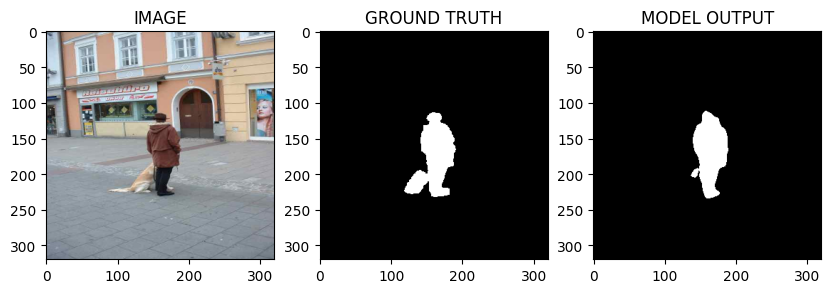

In [29]:
import importlib # Import importlib to reload the module
import numpy as np # Import numpy for type checking in helper function
import torch # Import torch for type checking in helper function

idx = 10  # You can change this index to view different examples
image, mask = validset[idx]

# Add a batch dimension for inference
image_batch = image.to(DEVICE).unsqueeze(0)

with torch.no_grad():
    logits = model(image_batch)

# Apply sigmoid and threshold to get binary mask
pred_mask = torch.sigmoid(logits).squeeze().cpu().numpy() > 0.5

# Complete content of helper.py including imports and the updated show_image function
new_helper_file_content = """import matplotlib.pyplot as plt
import numpy as np
import torch


def show_image(image, mask, pred_image=None):
    # Helper to prepare image for imshow
    def _prepare_img_for_imshow(img_data):
        if isinstance(img_data, torch.Tensor):
            img_data = img_data.permute(1, 2, 0).cpu().numpy()
        # If it's a numpy array with 3 dimensions and last dim is 1 (e.g., [H, W, 1]), squeeze it
        if isinstance(img_data, np.ndarray) and img_data.ndim == 3 and img_data.shape[2] == 1:
            img_data = img_data.squeeze(axis=-1)
        return img_data

    # Prepare all images first
    prepared_image = _prepare_img_for_imshow(image)
    prepared_mask = _prepare_img_for_imshow(mask)

    # Determine cmap for the main image
    image_cmap = 'gray' if prepared_image.ndim == 2 else None

    if pred_image is None:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.set_title('IMAGE')
        ax1.imshow(prepared_image, cmap=image_cmap)

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(prepared_mask, cmap='gray')

    else: # pred_image is not None
        prepared_pred_image = _prepare_img_for_imshow(pred_image)
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

        ax1.set_title('IMAGE')
        ax1.imshow(prepared_image, cmap=image_cmap)

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(prepared_mask, cmap='gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(prepared_pred_image, cmap='gray')
"""

# Write the modified content back to helper.py
with open('/content/Human-Segmentation-Dataset-master/helper.py', 'w') as f:
    f.write(new_helper_file_content)

# Reload the helper module to apply changes
importlib.reload(helper)

# Now, call the modified show_image function
helper.show_image(image, mask, pred_mask)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya